title: Shadow User ID Matching Data Quality Check for Web and Funnel
author: Claudia Dai
date: 2021-05-01  
region: EU
tags: acquire, shadow user, data quality, website, snowplow, signup
summary: Our backend data and tracking data show discrepancies in the number of shadow user IDs (and user IDs). The assumption is that, naturally, our BE data is robust. We are interested in how much cmd data can be matched to funnel data as we suspect that some data may be lost. In other words, FE data is missing some shadow user IDs that we have registered in the BE data. We would like to know how many (it should be 100%). This notebook takes a look at our data model flow and inspects any missing data. The queries can be run periodically and the notebook visualizes missing values over time.

# Shadow User ID Matching – Data Quality Check

In [1]:
%%capture
!pip install seaborn

In [2]:
import time
import warnings

warnings.filterwarnings("ignore")
from datetime import datetime
from dateutil import rrule, parser
import os
from os import path
from utils.datalib_database import df_from_sql
from IPython.display import Image

In [3]:
import pandas as pd

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16, 12)
import seaborn as sns

sns.set()

In [4]:
def timer(elapsed_time):
    return time.strftime("%H:%M:%S", time.gmtime(elapsed_time))


def generate_filename(folder, ticket_number, period, description, date_start, date_end):
    return f"{folder}{ticket_number}-{description}-extract-{period}-{date_start}-{date_end}.csv"


def query_data(query):
    return df_from_sql("redshiftreader", query)


def save_data(data, filename):
    data.to_csv(filename, index=False)


def get_data(query, filename):
    ts = time.time()
    data = query_data(query)
    te = time.time() - ts
    print("Finished querying data. Time elapsed: {}.".format(timer(te)))

    ts = time.time()
    save_data(data, filename)
    te = time.time() - ts
    print("Finished saving data. Time elapsed: {}.\n".format(timer(te)))


def check_file_exist(filename):
    return path.exists(filename)

In [5]:
def incremental_load(
    dates_start, dates_end, ticket_number, period, description, query_formatted, verbose
):
    for date_start, date_end in zip(dates_start, dates_end):
        filename = generate_filename(
            "data/", ticket_number, period, description, date_start, date_end
        )
        if check_file_exist(filename) == True:
            if verbose:
                print("{} already exists.".format(filename))
        else:
            if verbose:
                print("{} does not exist.\nGetting data...".format(filename))
            query = query_formatted(period, date_start, date_end)
            get_data(query, filename)


def merge_incremental_files(ticket_number, description, period, dates):
    fpattern = f"{ticket_number}-{description}-extract-{period}"
    relevant_files = [f"data/{f}" for f in os.listdir("data/") if fpattern in f]

    df = pd.DataFrame()
    for f in relevant_files:
        data = pd.read_csv(f)
        df = df.append(data, ignore_index=True)

    filename_merged = f"data/{fpattern}-merged-{dates[0]}-{dates[-1]}.csv"

    df.drop_duplicates(subset=None, inplace=True)

    save_data(df, filename_merged)

    del df

    return filename_merged, fpattern


def plot_data(data, title, subtitle, fpattern, dates):
    ax = sns.lineplot(data=data, x="dt", y="lost_perc", marker="o")

    ax.text(
        x=0.5,
        y=1.1,
        s=title,
        fontsize=24,
        weight="bold",
        ha="center",
        va="bottom",
        transform=ax.transAxes,
    )
    ax.text(
        x=0.5,
        y=1.03,
        s=subtitle,
        fontsize=15,
        alpha=0.75,
        ha="center",
        va="bottom",
        transform=ax.transAxes,
    )
    ax.set_ylim(0, 100)
    ax.set_xticklabels(data["dt"], rotation=90)
    fig = ax.get_figure()
    fig.savefig(f"{fpattern}-merged-{dates[0]}-{dates[-1]}.png")
    plt.tight_layout()
    plt.show()

In [6]:
ticket_number = "DATA-10792"  # insert: your ticket number
dtstart = "2019-01-01"  # choose: start date of analysis
period = "month"  # choose: month / week / day
verbose = False  # True if you want print statements, False if not

In [7]:
# dtend = datetime.today()
dtend = parser.parse("2021-04-01")
dates = []
if period == "month":
    for dt in rrule.rrule(rrule.MONTHLY, dtstart=parser.parse(dtstart), until=dtend):
        dates.append(dt.strftime("%Y-%m-%d"))
elif period == "week":
    for dt in rrule.rrule(rrule.WEEKLY, dtstart=parser.parse(dtstart), until=dtend):
        dates.append(dt.strftime("%Y-%m-%d"))
elif period == "day":
    for dt in rrule.rrule(rrule.DAILY, dtstart=parser.parse(dtstart), until=dtend):
        dates.append(dt.strftime("%Y-%m-%d"))
else:
    raise ValueError(
        'You have to indicate "month", "week", or "day" for the period variable.'
    )
dates_start = dates[:-1]
dates_end = dates[1:]

----

<a id='table_of_contents'></a>

# Table of Contents

## Introduction
- [What is this about?](#introduction)

## What is the current state of lost data?
- [Do we have all BE data (cmd shadow) in FE data (upper funnel)?](#cmd-upper-check)

## Where is this missing data coming from?
- [stg_event_userid](#stg_event_userid)
- [snowplow](#snowplow)
- [stg_web_userid](#stg_web_userid)
- [stg_upper_funnel](#stg_upper_funnel)

----

<a id='introduction'></a>

[Back to Table of Content](#table_of_contents)

# What is this about?

Our backend data and tracking data show discrepancies in the number of shadow user IDs (and user IDs). This notebook takes a look at our data model flow and inspects any missing data.

As shown below, both web and funnel data models make use of `stg_web_userid`. Both also make use of data from `snowplow`. `snowplow` is based on a set of `ksp_` tables.

Some background on our `ksp_` tables:
- `ksp_event_crab`: main table that contains all tracked events except unstructured events (these don't contain user id information)
- `ksp_web_crab`: a subset of ksp_event-Crab for all web events, includes information specific to events that were sent from web
- `ksp_event_types`: use to look up what each event type is (for page view and structured event)
- `ksp_event_userid`: product of in-app stitching algorithm mapping of event_id to shadow user id (don't use for web events or pre-SU events), contains shadow user ID associated with an event - either the original ID is sent with the event or the ID is derived through identity stitching
- `ksp_web_userid`: product of app stitching algorithm mapping of event_id to shadow user id for web events (use for web and pre-SU events), contains shadow user ID associated with an event - either the original ID is sent with the event or the ID is derived through identity stitching

## Web models

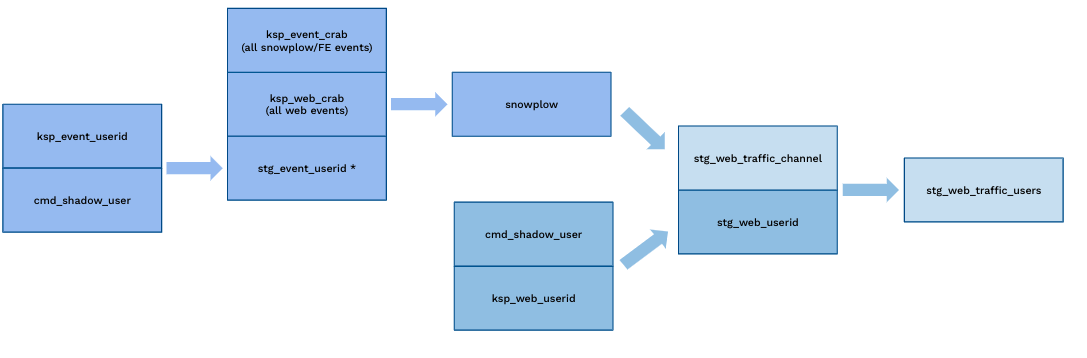

In [8]:
Image(filename="img/web-overview.png")

## Funnel models

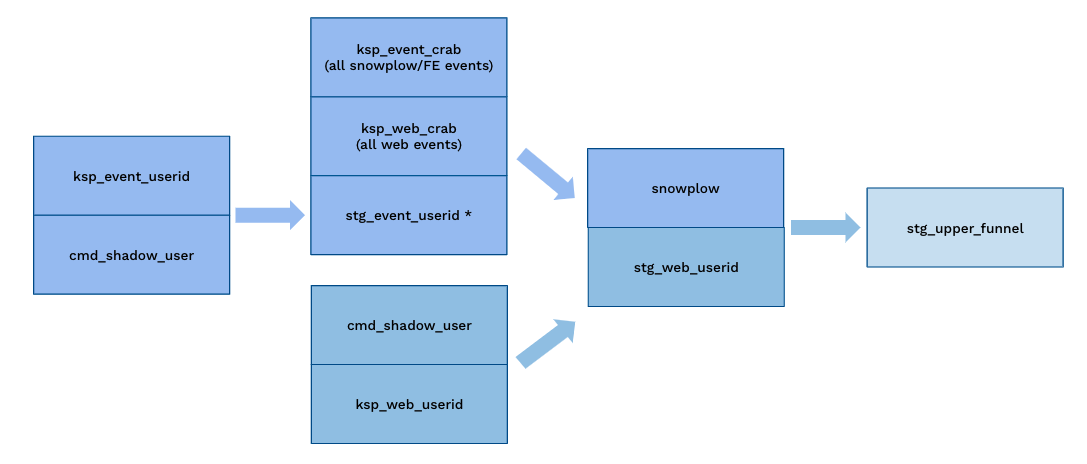

In [9]:
Image(filename="img/fun-overview.png")

----

<a id='cmd-upper-check'></a>

[Back to Table of Content](#table_of_contents)

# Do we have all BE data (cmd shadow) in FE data (upper funnel)? How many shadow user IDs in `cmd_shadow_user` are not found in `stg_upper_funnel`?

The assumption here is that, naturally, our BE data is robust (you can also do a check and will yield that pretty much all upper funnel data can be matched to cmd data. We are, however, interested in how much cmd data can be matched to funnel data as we suspect that some data may be lost. In other words, FE data is missing some shadow user IDs that we have registered in the BE data. We would like to know how many (**it should be 100%**).

In [10]:
def query_formatted(period, date_start, date_end):
    return f"""
SELECT
    DATE_TRUNC('{period}', cmd_shadow_user.created) AS dt,
    COUNT(DISTINCT cmd_shadow_user.id) AS cmd,
    COUNT(DISTINCT dbt.stg_upper_funnel.shadow_user_id) AS upp,
    COUNT(DISTINCT CASE WHEN dbt.stg_upper_funnel.shadow_user_id IS NULL THEN cmd_shadow_user.id END) AS lost_ids,
    100 * lost_ids::float / cmd::float AS lost_perc
FROM
    cmd_shadow_user
LEFT JOIN
    dbt.stg_upper_funnel
ON
    cmd_shadow_user.id = dbt.stg_upper_funnel.shadow_user_id
WHERE 1=1
    AND cmd_shadow_user.created >= '{date_start}'  
    AND cmd_shadow_user.created < '{date_end}'  
GROUP BY 1
ORDER BY 1
    """

In [11]:
description = "check-cmd-upp"

In [12]:
incremental_load(
    dates_start, dates_end, ticket_number, period, description, query_formatted, verbose
)

In [13]:
filename_merged, fpattern = merge_incremental_files(
    ticket_number, description, period, dates
)

In [14]:
check_cmd_upp = pd.read_csv(filename_merged)
check_cmd_upp

,dt,cmd,upp,lost_ids,lost_perc
0,2019-01-01,360964,21817,339147,93.955907
1,2019-02-01,684893,23272,661621,96.602097
2,2019-03-01,1100349,27344,1073005,97.514970
3,2019-04-01,279474,19635,259839,92.974302
4,2019-05-01,281028,21236,259792,92.443458
5,2019-06-01,278722,22308,256414,91.996326
6,2019-07-01,337069,32812,304257,90.265495
7,2019-08-01,351365,206037,145328,41.360978
8,2019-09-01,329564,310627,18937,5.746077
9,2019-10-01,335511,313104,22407,6.678470


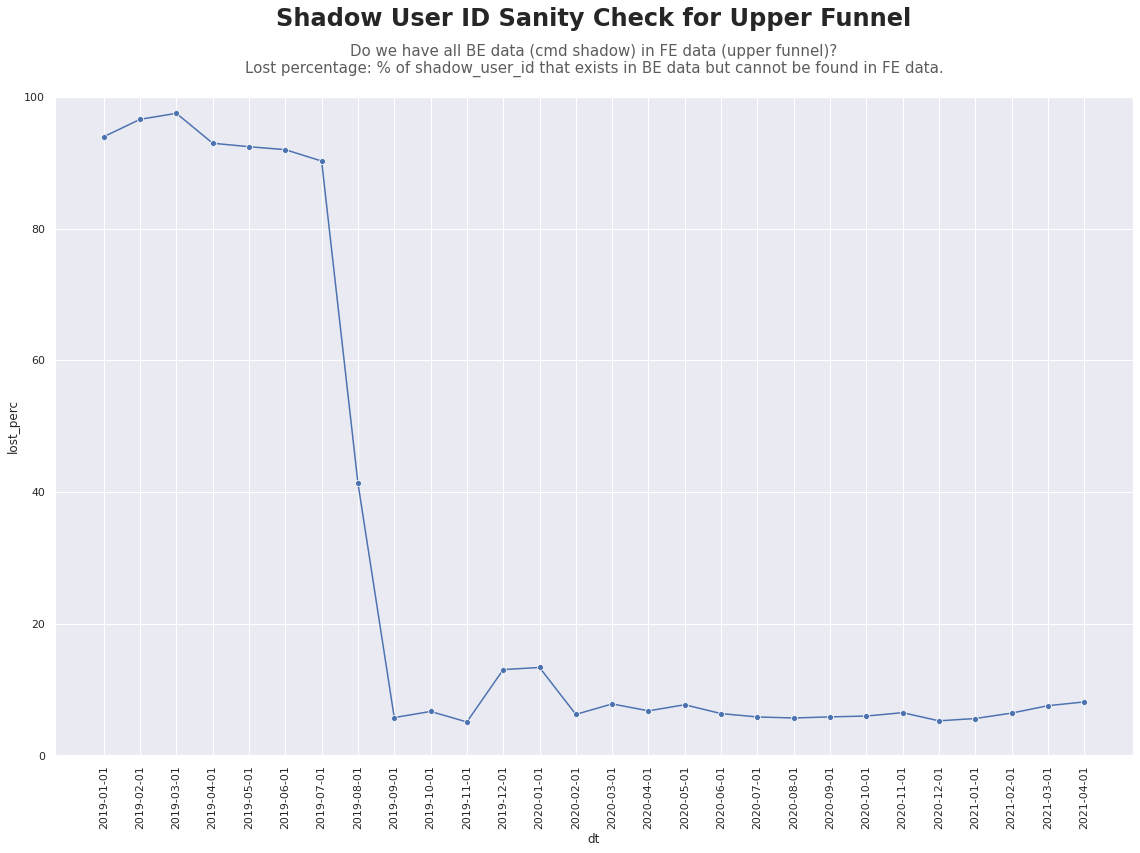

In [15]:
plot_data(
    data=check_cmd_upp,
    title="Shadow User ID Sanity Check for Upper Funnel",
    subtitle="Do we have all BE data (cmd shadow) in FE data (upper funnel)?\nLost percentage: % of shadow_user_id that exists in BE data but cannot be found in FE data.",
    fpattern=fpattern,
    dates=dates,
)

> In 2019, FE tracking for funnel was introduced. Prior to this, it was done with page view events. We should look at the more recent months for evaluation. Our assumption is that our BE data is complete. All sign ups that we have are in BE. All sign ups have to go through the sign up funnel to register their account, so all sign ups should also be found in FE data – **but we cannot**. We are lately missing 5-10% of shadow_user_ids in FE every month. **Why?**

----

<a id='stg_event_userid'></a>

[Back to Table of Content](#table_of_contents)

# `stg_event_userid`

```SQL
FROM ksp_event_userid
LEFT JOIN cmd_shadow_user
ON shadow_user_id
```

This table takes `ksp_event_userid` as a base and left joins to `cmd_shadow_user` on `shadow_user_id`. It looks for all the `shadow_user_id` we have in backend to enrich the data.

**What could go wrong here?** There might be shadow user IDs in `cmd_shadow_user` that can't be matched to `ksp_event_userid` (they are missing due to some reason), and we would lose information here. We will check if that is the case.

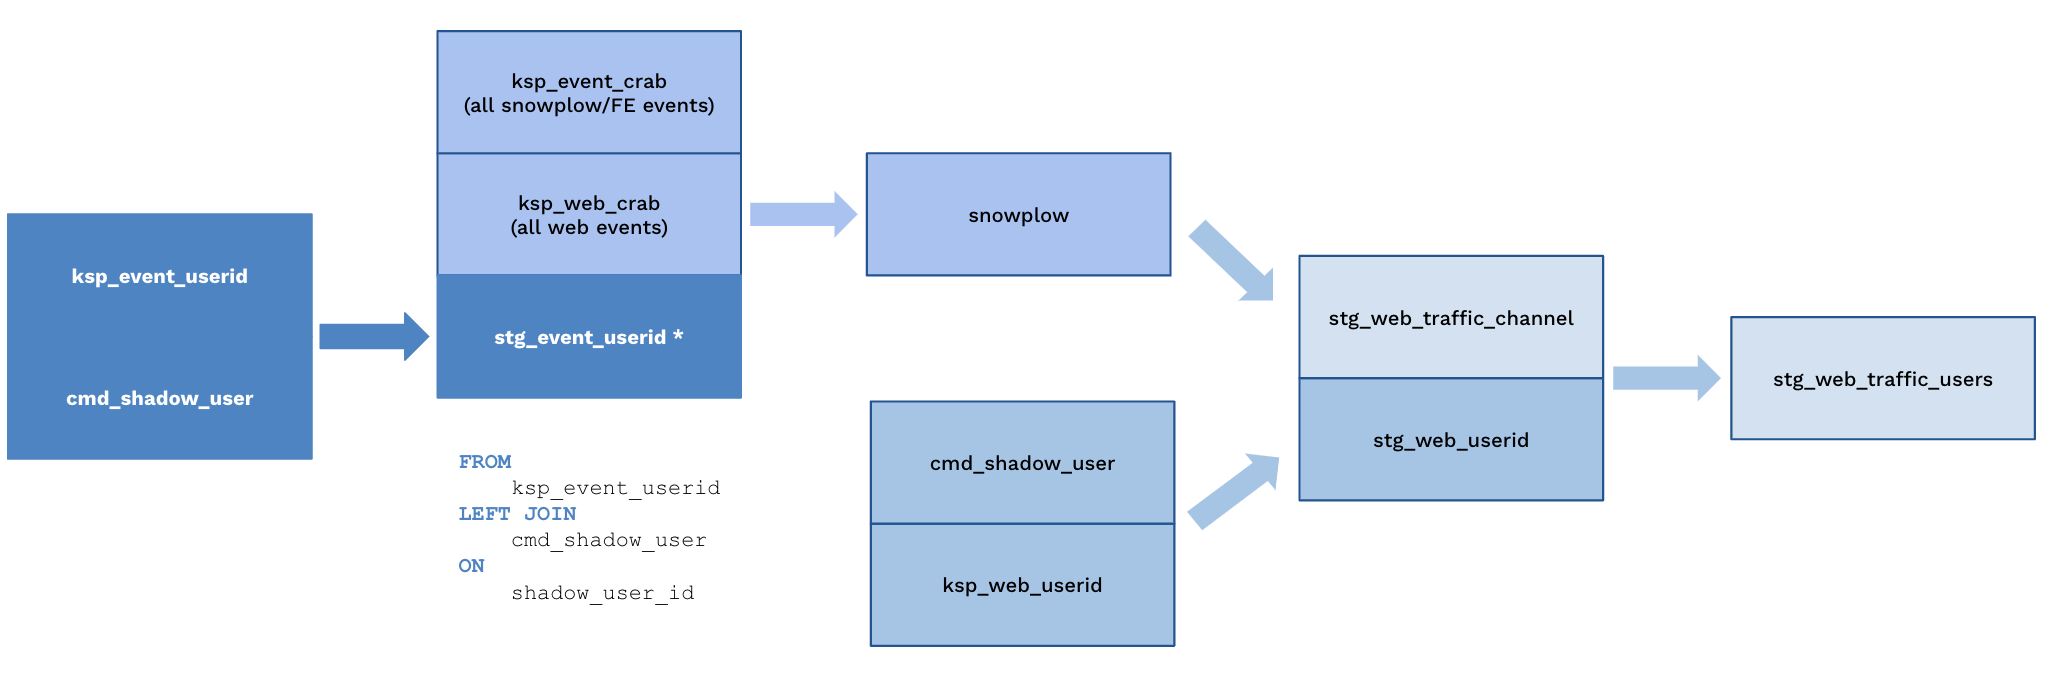

In [16]:
Image(filename="img/web-seu.png")

### How many `shadow_user_id` in `ksp_event_userid` do not exist in `cmd_shadow_user`?

In [17]:
def query_formatted(period, date_start, date_end):
    return f"""
SELECT
    DATE_TRUNC('{period}', ksp_event_userid.collector_tstamp) AS dt,
    COUNT(DISTINCT ksp_event_userid.user_id) AS ksp,
    COUNT(DISTINCT cmd_shadow_user.id) AS cmd,
    COUNT(DISTINCT CASE WHEN cmd_shadow_user.id IS NULL AND ksp_ip_geo.country != 'US' THEN ksp_event_userid.user_id END) AS lost_ids,
    100 * lost_ids::float / ksp::float AS lost_perc
FROM
    ksp_event_userid
LEFT JOIN
    cmd_shadow_user
ON
    cmd_shadow_user.id = ksp_event_userid.user_id 
LEFT JOIN 
    ksp_ip_geo
ON 
    ksp_ip_geo.event_id = ksp_event_userid.event_id
WHERE 1=1
    AND ksp_event_userid.collector_tstamp >= '{date_start}'
    AND ksp_event_userid.collector_tstamp < '{date_end}'
GROUP BY 1
ORDER BY 1
    """

In [18]:
description = "spe-cmd-shadow"

In [19]:
incremental_load(
    dates_start, dates_end, ticket_number, period, description, query_formatted, verbose
)

In [20]:
filename_merged, fpattern = merge_incremental_files(
    ticket_number, description, period, dates
)

In [21]:
spe_cmd_shadow = pd.read_csv(filename_merged)
spe_cmd_shadow

,dt,ksp,cmd,lost_ids,lost_perc
0,2019-01-01,1278467,1277815,652,0.050999
1,2019-02-01,1554869,1554155,714,0.045920
2,2019-03-01,2105333,2104529,804,0.038189
3,2019-04-01,1408276,1403381,4895,0.347588
4,2019-05-01,1453043,1444593,8450,0.581538
5,2019-06-01,1440658,1434664,5994,0.416060
6,2019-07-01,1553509,1535963,17546,1.129443
7,2019-08-01,1618963,1576917,42046,2.597095
8,2019-09-01,1695351,1639547,55804,3.291590
9,2019-10-01,1692522,1640925,51597,3.048528


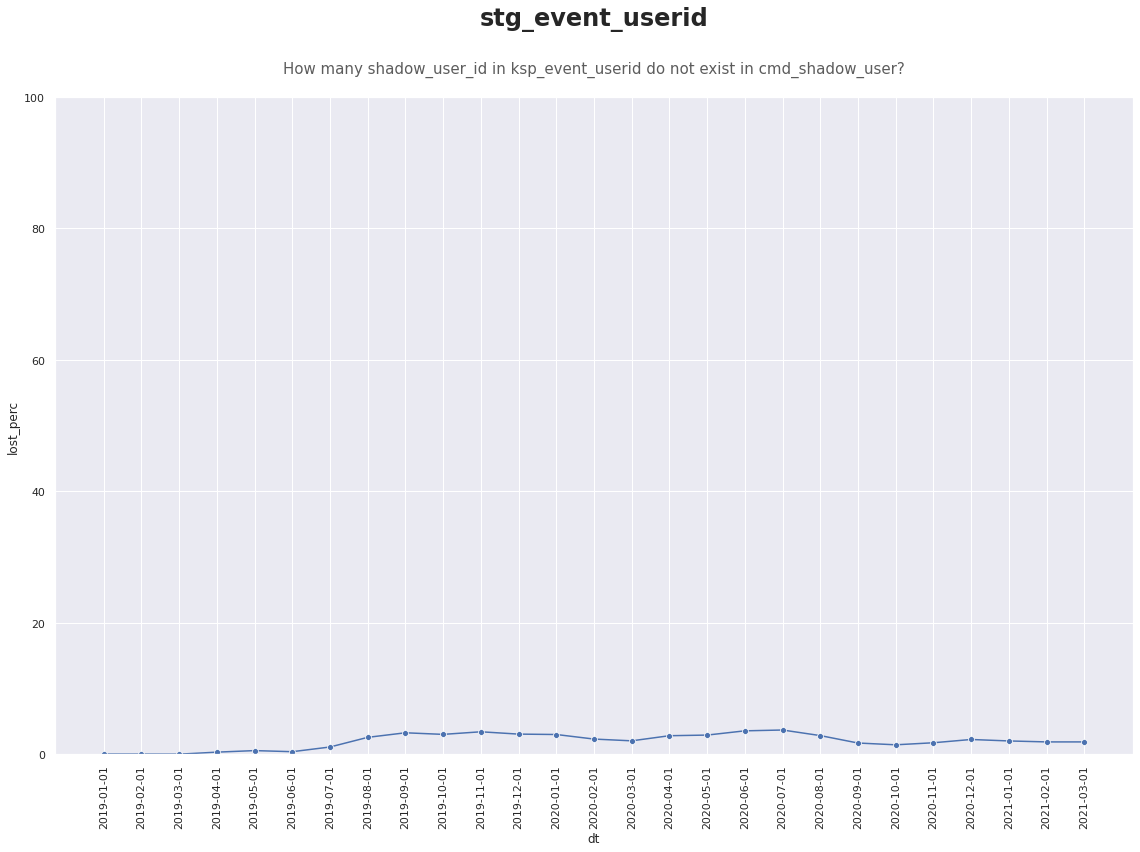

In [22]:
plot_data(
    data=spe_cmd_shadow,
    title="stg_event_userid",
    subtitle="How many shadow_user_id in ksp_event_userid do not exist in cmd_shadow_user?",
    fpattern=fpattern,
    dates=dates,
)

> Over time, we have about 1-3% of shadow user IDs in `ksp_event_userid` that cannot be traced back to `cmd_shadow_user`. This could be US people. Unfortunately, the query times out for me if I add `AND ksp_ip_geo.country != 'US'` to the query, so this **would have to be checked in a different way**.

### The other way around: How many `shadow_user_id` in `cmd_shadow_user` do not exist in `ksp_event_userid`?

Unlike above query where US people could play a role, this query is more important: `cmd_shadow_user` contains non-US folks. We do expect to find all shadow user IDs from `cmd_shadow_user` in `ksp_event_userid` since there should be events for every shadow user ID that we have stored in the cmd table.

In [23]:
def query_formatted(period, date_start, date_end):
    return f"""
SELECT
    DATE_TRUNC('{period}', cmd_shadow_user.created) AS dt,
    COUNT(DISTINCT cmd_shadow_user.id) AS cmd,
    COUNT(DISTINCT ksp_event_userid.user_id) AS ksp,
    COUNT(DISTINCT CASE WHEN ksp_event_userid.user_id IS NULL THEN cmd_shadow_user.id END) AS lost_ids,
    100 * lost_ids::float / ksp::float AS lost_perc
FROM
    cmd_shadow_user
LEFT JOIN
    ksp_event_userid
ON
    cmd_shadow_user.id = ksp_event_userid.user_id 
WHERE 1=1
    AND cmd_shadow_user.created >= '{date_start}'
    AND cmd_shadow_user.created < '{date_end}'
GROUP BY 1
ORDER BY 1
    """

In [24]:
description = "cmd-spe-shadow"

In [25]:
incremental_load(
    dates_start, dates_end, ticket_number, period, description, query_formatted, verbose
)

In [26]:
filename_merged, fpattern = merge_incremental_files(
    ticket_number, description, period, dates
)

In [27]:
cmd_spe_shadow = pd.read_csv(filename_merged)
cmd_spe_shadow

,dt,cmd,ksp,lost_ids,lost_perc
0,2019-01-01,360964,347458,13506,3.887089
1,2019-02-01,684893,606878,78015,12.855137
2,2019-03-01,1100349,889487,210862,23.706024
3,2019-04-01,279474,270600,8874,3.279379
4,2019-05-01,281028,274231,6797,2.478567
5,2019-06-01,278722,271972,6750,2.481873
6,2019-07-01,337069,324972,12097,3.722475
7,2019-08-01,351365,337870,13495,3.994140
8,2019-09-01,329564,320989,8575,2.671431
9,2019-10-01,335511,325927,9584,2.940536


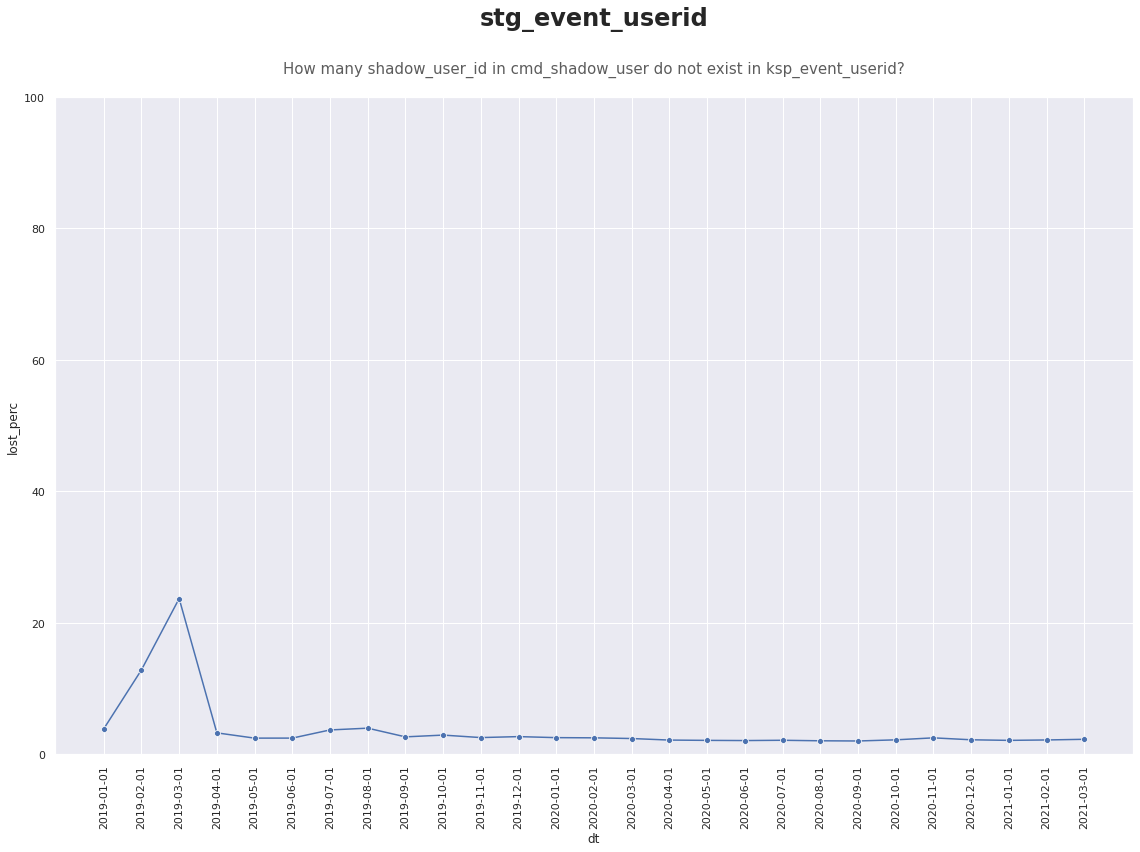

In [28]:
plot_data(
    data=cmd_spe_shadow,
    title="stg_event_userid",
    subtitle="How many shadow_user_id in cmd_shadow_user do not exist in ksp_event_userid?",
    fpattern=fpattern,
    dates=dates,
)

> We miss on average 2-3% of data - shadow user IDs that we have registered in cmd cannot be found in our event data. **Is this a user stitching problem?**

----

<a id='snowplow'></a>

[Back to Table of Content](#table_of_contents)

# `snowplow`

```SQL
FROM ksp_event_crab
INNER JOIN ksp_event_types ON event_type
LEFT JOIN ksp_web_crab ON event_id
LEFT JOIN ksp_event_userid/stg_event_userid ON event_id
LEFT JOIN ksp_ip_geo ON event_id
```

This table takes `ksp_event_crab` as a base containing all tracked events except unstructured events, and enriches it with information on each `event_type` from `ksp_event_types`, information specific to events that were sent from web from `ksp_web_crab`, and user information from `ksp_event_userid` and `ksp_web_userid`.

`ksp_event_types` and `ksp_ip_geo` are likely less of an issue. However, since `ksp_event_types` comes with an INNER join, we'll do a quick check on it regardless. INNER joins may trigger data loss as well so we should be complete here with our analysis.

We also shouldn't expect that every event in `ksp_event_crab` matches to an event in `ksp_web_crab`.

The most important check here would be whether we can match every event in `ksp_event_crab` to `ksp_event_userid` / `stg_event_userid`.

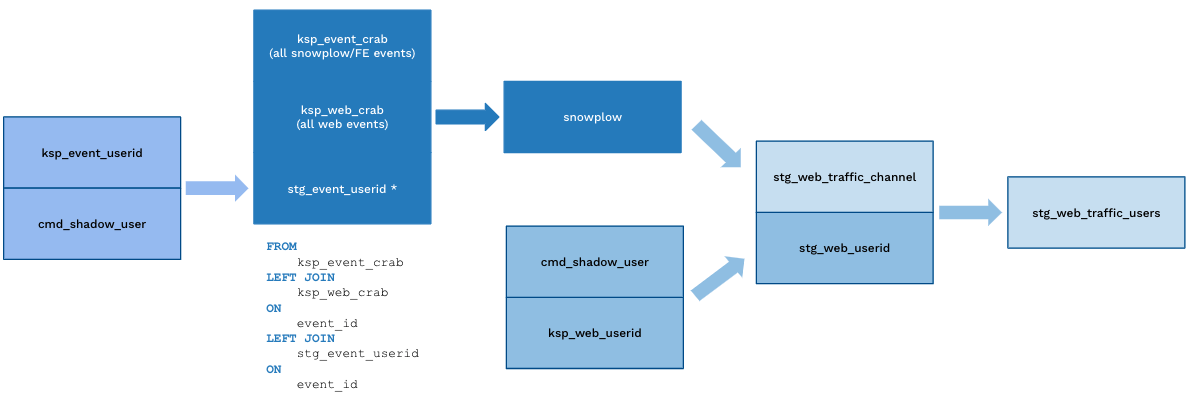

In [29]:
Image(filename="img/web-spw.png")

### How much % EVENT_ID get lost with the INNER JOIN? How much in `ksp_event_crab` does not exist in `ksp_event_types`?

In [30]:
def query_formatted(period, date_start, date_end):
    return f"""
SELECT
    DATE_TRUNC('{period}', ksp_event_crab.collector_tstamp) AS dt,
    COUNT(DISTINCT ksp_event_crab.event_type) AS crab,
    COUNT(DISTINCT ksp_event_types.event_type) AS type,
    COUNT(DISTINCT CASE WHEN ksp_event_types.event_type IS NULL THEN ksp_event_crab.event_type END) AS lost_types,
    100 * lost_types::float / NULLIF(crab, 0)::float AS lost_perc
FROM
    ksp_event_crab
LEFT JOIN
    ksp_event_types
ON
    ksp_event_crab.event_type = ksp_event_types.event_type
WHERE 1=1
    AND ksp_event_crab.collector_tstamp >= '{date_start}'
    AND ksp_event_crab.collector_tstamp < '{date_end}'
GROUP BY 1
ORDER BY 1
    """

In [31]:
description = "ksp-event-types"

In [32]:
incremental_load(
    dates_start, dates_end, ticket_number, period, description, query_formatted, verbose
)

In [33]:
filename_merged, fpattern = merge_incremental_files(
    ticket_number, description, period, dates
)

In [34]:
ksp_event_types = pd.read_csv(filename_merged)
ksp_event_types

,dt,crab,type,lost_types,lost_perc
0,2019-01-01,312,312,0,0.000000
1,2019-02-01,347,347,0,0.000000
2,2019-03-01,359,359,0,0.000000
3,2019-04-01,357,357,0,0.000000
4,2019-05-01,361,361,0,0.000000
5,2019-06-01,361,361,0,0.000000
6,2019-07-01,369,369,0,0.000000
7,2019-08-01,387,386,1,0.258398
8,2019-09-01,411,410,1,0.243309
9,2019-10-01,376,375,1,0.265957


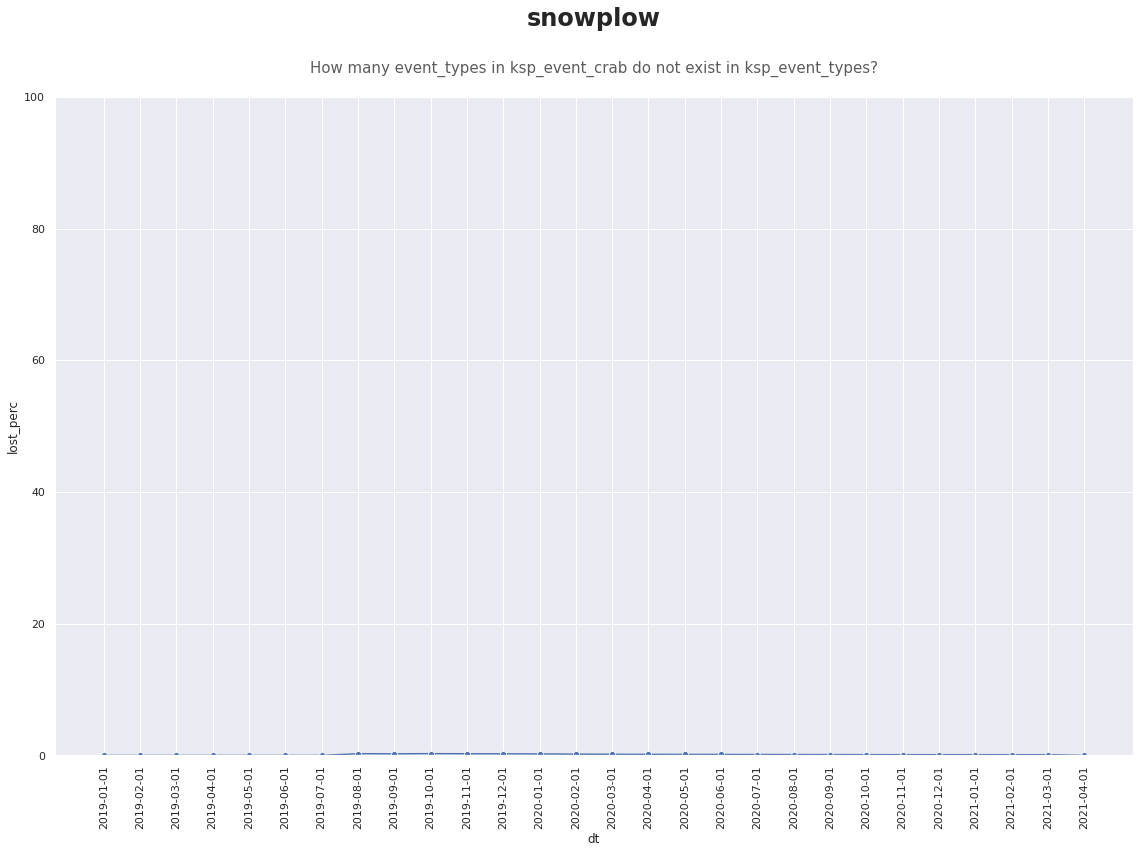

In [35]:
plot_data(
    data=ksp_event_types,
    title="snowplow",
    subtitle="How many event_types in ksp_event_crab do not exist in ksp_event_types?",
    fpattern=fpattern,
    dates=dates,
)

> Curiously, we seem to have one `event_type` value in `ksp_event_crab` that cannot be matched to `ksp_event_types`. Let's see which one that is.

In [36]:
dt_lost_types = ksp_event_types[ksp_event_types.lost_types > 0].dt.to_list()
date_start = min(dt_lost_types)
date_end = max(dt_lost_types)

In [37]:
def query_formatted(period, date_start, date_end):
    return f"""
SELECT
    DISTINCT CASE WHEN ksp_event_types.event_type IS NULL THEN ksp_event_crab.event_type END AS lost_types
FROM
    ksp_event_crab
LEFT JOIN
    ksp_event_types
ON
    ksp_event_crab.event_type = ksp_event_types.event_type
WHERE 1=1
    AND ksp_event_crab.collector_tstamp >= '{date_start}'
    AND ksp_event_crab.collector_tstamp <= '{date_end}'
GROUP BY 1
ORDER BY 1
    """

In [38]:
description = "ksp-event-losttypes"

In [39]:
incremental_load(
    dates_start, dates_end, ticket_number, period, description, query_formatted, verbose
)

In [40]:
filename_merged, fpattern = merge_incremental_files(
    ticket_number, description, period, dates
)

In [41]:
ksp_event_losttypes = pd.read_csv(filename_merged)
ksp_event_losttypes

,lost_types
0,NaN
1,659.0


> The event type in `ksp_event_crab` that cannot be matched to any values in `ksp_event_types` is **659**. What event is that? This should be investigated.

### How many events in `ksp_event_userid` / `stg_event_userid` do not exist in `ksp_event_crab`?

aka: can we match every event in our user data to the events in `ksp_event_crab`? we should be able to, otherwise: red flag.

In [42]:
def query_formatted(period, date_start, date_end):
    return f"""
SELECT
    DATE_TRUNC('{period}', dbt.stg_event_userid.collector_tstamp) AS dt,
    COUNT(DISTINCT dbt.stg_event_userid.event_id) AS user,
    COUNT(DISTINCT ksp_event_crab.event_id) AS event,
    COUNT(DISTINCT CASE WHEN ksp_event_crab.event_id IS NULL THEN dbt.stg_event_userid.event_id END) AS lost_ids,
    100 * lost_ids::float / NULLIF(event, 0)::float AS lost_perc
FROM
    dbt.stg_event_userid
LEFT JOIN
    ksp_event_crab
ON
    ksp_event_crab.event_id = dbt.stg_event_userid.event_id
WHERE 1=1
    AND ksp_event_crab.collector_tstamp >= '{date_start}'
    AND ksp_event_crab.collector_tstamp < '{date_end}'
GROUP BY 1
ORDER BY 1
    """

> This query is too heavy to run. **We need to find another way to test whether we can match all event IDs with one another, or if some event IDs in FE might actually be lost (?)**

----

<a id='stg_web_userid'></a>

[Back to Table of Content](#table_of_contents)

# `stg_web_userid`

```SQL
FROM ksp_web_userid
INNER JOIN cmd_shadow_user
ON shadow_user_id
```

`stg_web_userid` is used for both web and funnel data.

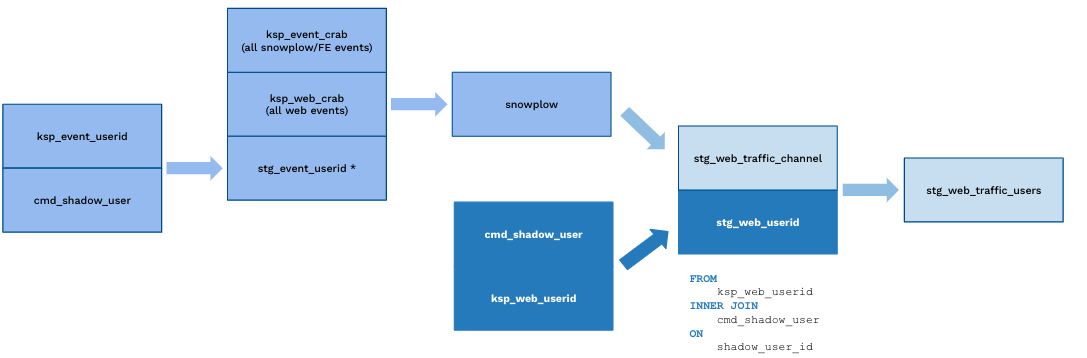

In [43]:
Image(filename="img/web-swu.png")

### How many shadow user IDs (excluding US data from missing data since US data is rightfully supposed to be missing) in ksp_web_userid do not exist in cmd_shadow_user? 

In [44]:
def query_formatted(period, date_start, date_end):
    return f"""
SELECT
    DATE_TRUNC('{period}', ksp_web_userid.collector_tstamp) AS dt,
    COUNT(DISTINCT ksp_web_userid.user_id) AS ksp,
    COUNT(DISTINCT cmd_shadow_user.id) AS cmd,
    COUNT(DISTINCT CASE WHEN cmd_shadow_user.id IS NULL AND ksp_ip_geo.country != 'US' THEN ksp_web_userid.user_id END) AS lost_ids,
    100 * lost_ids::float / NULLIF(ksp, 0)::float AS lost_perc
FROM
    ksp_web_userid
LEFT JOIN
    cmd_shadow_user
ON
    cmd_shadow_user.id = ksp_web_userid.user_id 
LEFT JOIN 
    ksp_ip_geo
ON 
    ksp_ip_geo.event_id = ksp_web_userid.event_id
WHERE 1=1
    AND ksp_web_userid.collector_tstamp >= '{date_start}'
    AND ksp_web_userid.collector_tstamp < '{date_end}'
GROUP BY 1
ORDER BY 1
    """

In [45]:
description = "spw-cmd-shadow-no-us"

In [46]:
incremental_load(
    dates_start, dates_end, ticket_number, period, description, query_formatted, verbose
)

In [47]:
filename_merged, fpattern = merge_incremental_files(
    ticket_number, description, period, dates
)

In [48]:
spw_cmd_shadow_no_us = pd.read_csv(filename_merged)
spw_cmd_shadow_no_us

,dt,ksp,cmd,lost_ids,lost_perc
0,2019-01-01,542366,542196,142,0.026182
1,2019-02-01,772260,771992,220,0.028488
2,2019-03-01,1272282,1271869,303,0.023815
3,2019-04-01,673601,669120,755,0.112084
4,2019-05-01,699903,692126,1191,0.170166
5,2019-06-01,667894,662373,1223,0.183113
6,2019-07-01,733648,717125,3170,0.432087
7,2019-08-01,748406,709026,4208,0.562262
8,2019-09-01,730190,681449,2486,0.340459
9,2019-10-01,681730,640433,20823,3.054435


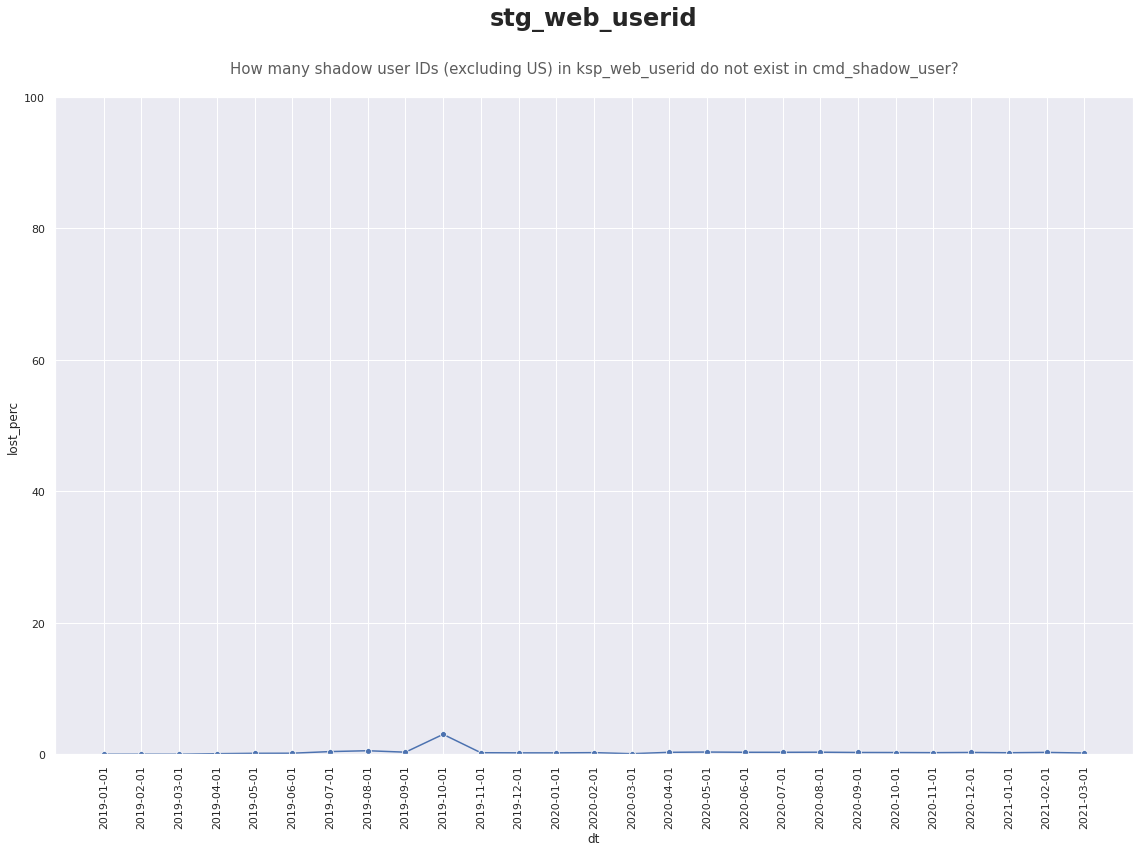

In [49]:
plot_data(
    data=spw_cmd_shadow_no_us,
    title="stg_web_userid",
    subtitle="How many shadow user IDs (excluding US) in ksp_web_userid do not exist in cmd_shadow_user?",
    fpattern=fpattern,
    dates=dates,
)

> Most of the data we lose are due to US data – so this is fine.

----

<a id='stg_upper_funnel'></a>

[Back to Table of Content](#table_of_contents)

# stg_upper_funnel [FUNNEL]

```SQL
FROM snowplow
LEFT JOIN stg_web_userid
ON event_id
```

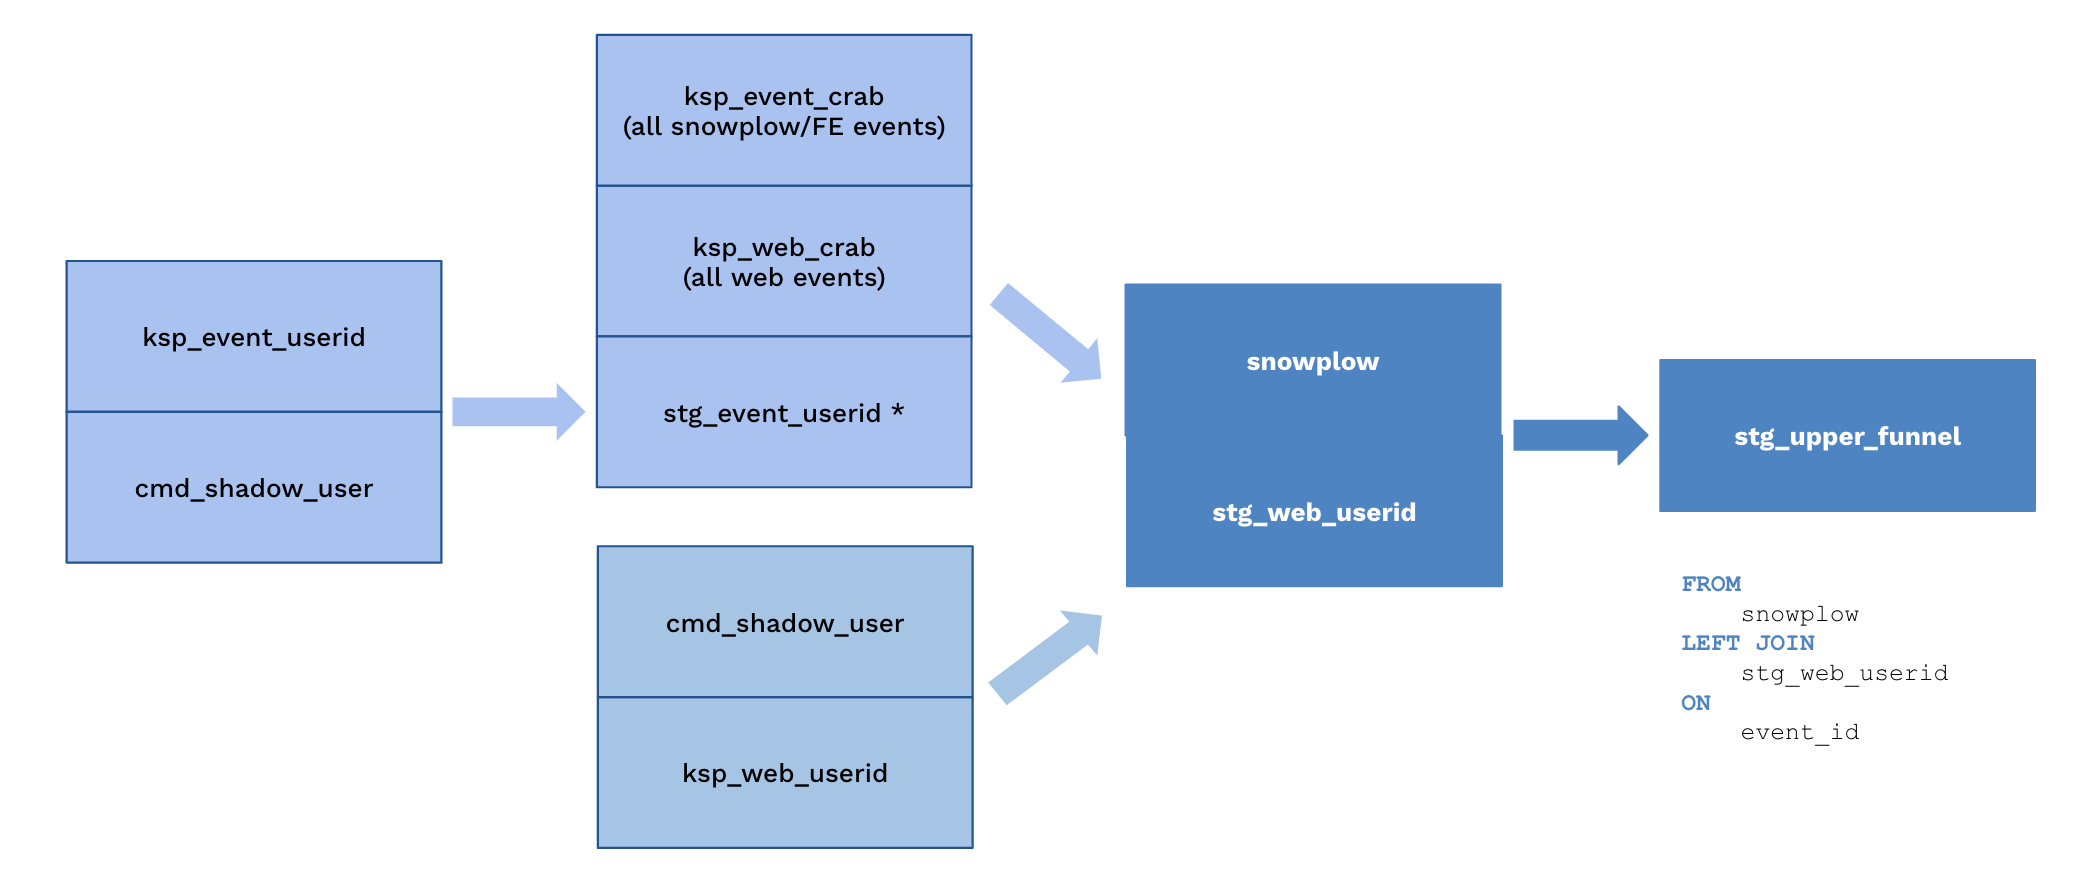

In [50]:
Image(filename="img/fun-suf.png")

### How many event IDs in snowplow do not exist in stg_web_userid during `phone-number` step?

`phone-number` step is the critical step where users all should have a shadow user ID assigned once they reach this step. So we expect a 100% match.

In [51]:
def query_formatted(period, date_start, date_end):
    return f"""
SELECT
    DATE_TRUNC('{period}', dbt.snowplow.collector_tstamp) AS dt,
    COUNT(DISTINCT dbt.snowplow.event_id) AS spl,
    COUNT(DISTINCT dbt.stg_web_userid.event_id) AS swu,
    COUNT(DISTINCT CASE WHEN dbt.stg_web_userid.event_id IS NULL THEN snowplow.event_id END) AS lost_ids,
    100 * lost_ids::float / spl::float AS lost_perc
FROM
    dbt.snowplow
LEFT JOIN
    dbt.stg_web_userid
ON
    dbt.stg_web_userid.event_id = dbt.snowplow.event_id
WHERE 1=1
    AND dbt.snowplow.collector_tstamp >= '{date_start}'
    AND dbt.snowplow.collector_tstamp < '{date_end}'
    AND dbt.snowplow.event_type = 630
    and JSON_EXTRACT_PATH_TEXT(dbt.snowplow.se_label, 'step', True) = 'phone-number'
GROUP BY 1
ORDER BY 1
    """

In [52]:
description = "spl-swu-event-phone"

In [53]:
incremental_load(
    dates_start, dates_end, ticket_number, period, description, query_formatted, verbose
)

In [54]:
filename_merged, fpattern = merge_incremental_files(
    ticket_number, description, period, dates
)

In [55]:
spl_swu_event_phone = pd.read_csv(filename_merged)
spl_swu_event_phone

,dt,spl,swu,lost_ids,lost_perc
0,2019-06-01,47,0,47,100.000000
1,2019-07-01,7680,0,7680,100.000000
2,2019-08-01,295090,260161,34929,11.836728
3,2019-09-01,452490,410560,41930,9.266503
4,2019-10-01,476607,435298,41309,8.667309
5,2019-11-01,465667,404509,61158,13.133419
6,2019-12-01,340267,292899,47368,13.920833
7,2020-01-01,367608,317736,49872,13.566625
8,2020-02-01,372818,330298,42520,11.405029
9,2020-03-01,550710,508244,42466,7.711137


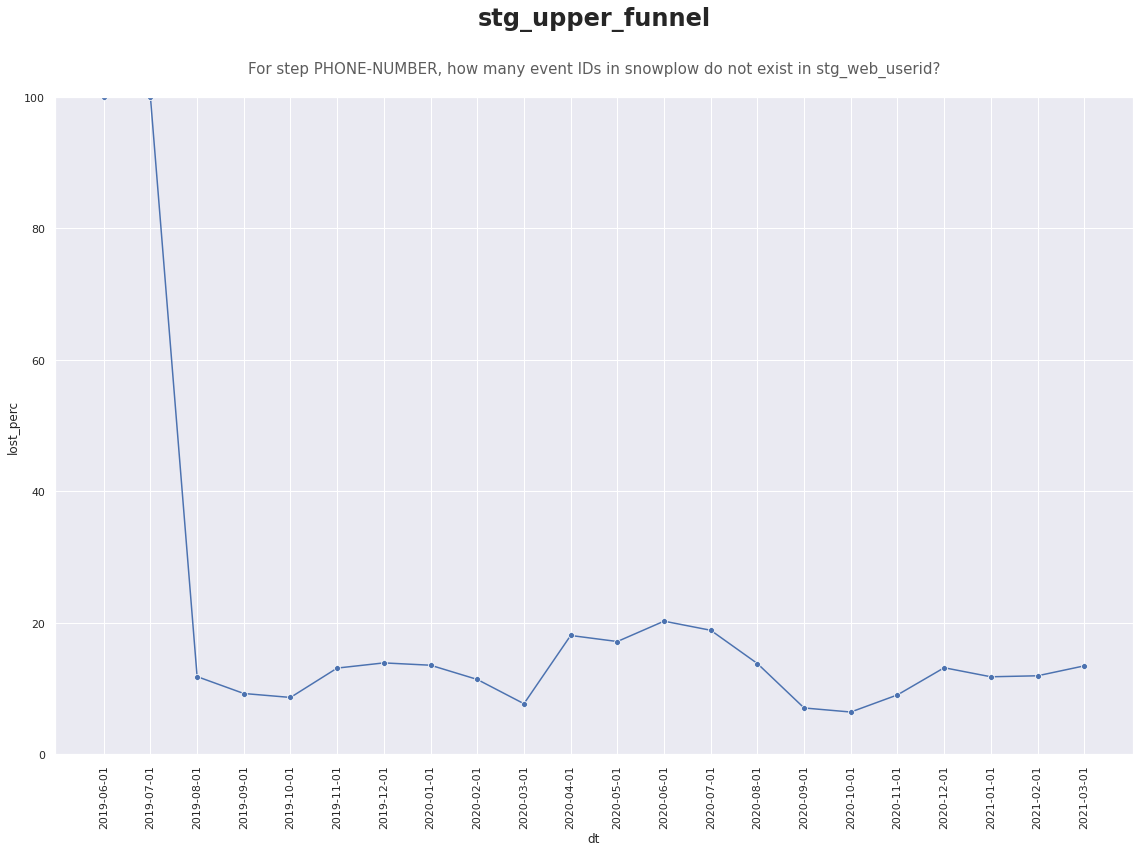

In [56]:
plot_data(
    data=spl_swu_event_phone,
    title="stg_upper_funnel",
    subtitle="For step PHONE-NUMBER, how many event IDs in snowplow do not exist in stg_web_userid?",
    fpattern=fpattern,
    dates=dates,
)

> We are still missing data even at start of `phone-number` step. **Why is that?**

----

# Summary & next steps

## Shadow user IDs

**How many shadow_user_id in `cmd_shadow_user` do not exist in `ksp_event_userid`?** 
> 2-3% (should be 0%). It could be a user stitching issue. Is there a way for us to check how many and which users get stitched? Can we cross check these numbers?

**How many shadow user IDs in `cmd_shadow_user` are not found in `stg_upper_funnel`?** 
> 5-10% (should be 0%). We still end up with more data lost further down the model stream. Some of the missing data is coming from the `cmd_shadow_user` <> `ksp_event_userid` (potential) user stitching issue. Where is the rest coming from? Some could come from the snowplow model set up, see question **How many events in ksp_event_userid / stg_event_userid do not exist in ksp_event_crab**.

## Event IDs

**How many events in ksp_event_userid / stg_event_userid do not exist in ksp_event_crab**:
> Unknown. This query is too heavy to run. We need to find another way to test whether we can match all event IDs with one another, or if some event IDs in FE might actually be lost.

**How many event IDs in snowplow do not exist in stg_web_userid during phone-number step?**: 
> 10-20% (should be 0%). This is quite a lot. Why is that?

## Event types

**We have one event type in ksp_event_crab that cannot be matched to any values in ksp_event_types:** 
> 659. What event is that? This should be investigated.